<a href="https://colab.research.google.com/github/opensites/colab-notebooks-public/blob/main/models/GPT_J_sample_sight_word_sentences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install enum

In [4]:
# Import Tensorflow 2.0
import enum
import tensorflow as tf
from tensorflow.keras import layers
import math

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) >= 0

Now we can upload the data files from our computer (access using the [tutorial linked here](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92))

In [5]:
from google.colab import files
uploaded = files.upload()

Saving train-prompt2.csv to train-prompt2.csv


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# load the dataset
import io
df_prompt2 = pd.read_csv(io.BytesIO(uploaded['train-prompt2.csv']))
df_prompt2["Response"] = "startseqtok " + df_prompt2["Response"] + " endseqtok"
print(df_prompt2["Response"].head(5))

0    startseqtok The frog is by the cat on the log....
1    startseqtok The cat may play with the rat day....
2         startseqtok The mat is by the cat. endseqtok
3                 startseqtok The sun is up. endseqtok
4             startseqtok It is sunny today. endseqtok
Name: Response, dtype: object


In [8]:
# Make a text-only dataset (without labels), then call adapt
all_data_tensor = tf.constant(df_prompt2.astype(str).values)
condensed_data_tensor = tf.reshape(all_data_tensor,[-1])

# number of unique words in the dataset after punctuation filtering
word_count_layer = layers.TextVectorization()
word_count_layer.adapt(condensed_data_tensor)
num_words = len(word_count_layer.get_vocabulary())
print(f'There are {num_words} unique words in this dataset')
print(word_count_layer.get_vocabulary()[0:10])

There are 753 unique words in this dataset
['', '[UNK]', 'the', 'startseqtok', 'endseqtok', 'is', 'i', 'a', 'to', 'you']


In [9]:
# tokenizer
# https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
# https://www.tensorflow.org/tutorials/keras/text_classification
max_features = math.floor(num_words * 1.5)
sequence_length = 100

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    ngrams=3,
    output_sequence_length=sequence_length)

# build vocab for this dataset
vectorize_layer.adapt(condensed_data_tensor)

# save the vocabulary as a standard python list
vocab = vectorize_layer.get_vocabulary()

# how far did ngram truly go
max_ngram_size = 0
for item in vocab:
    max_ngram_size = max(max_ngram_size, len(item.split()))


print(f'The maximum ngram found was {max_ngram_size}.')

# # see some vocab details
print(" 10 ---> ", vocab[10])
print(" 50 ---> ", vocab[50])
print(" -1 ---> ", vocab[-1])
print(f'Vocabulary size: {len(vocab)}')
print('startseqtok' in vocab)
print('endseqtok' in vocab)

The maximum ngram found was 3.
 10 --->  cat
 50 --->  the sun
 -1 --->  startseqtok i said
Vocabulary size: 1129
True
True


In [10]:

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.1, test_split=0.1):

    total_split = train_split + test_split + val_split
    if total_split != 1:
      train_split = train_split / total_split
      test_split = test_split / total_split
      val_split = val_split / total_split

    # Specify seed to always have the same split distribution between runs
    df_shuffled = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(train_split * len(df)), int((train_split + val_split) * len(df))]
    
    train_ds, val_ds, test_ds = np.split(df_shuffled, indices_or_sections)
    
    return train_ds, val_ds, test_ds

In [11]:
# see article here: https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
# and docs here: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = ds.cardinality().numpy()
    total_split = train_split + test_split + val_split
    if total_split != 1:
      train_split = train_split / total_split
      test_split = test_split / total_split
      val_split = val_split / total_split

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=2011)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
ds_all = tf.data.Dataset.from_tensor_slices(all_data_tensor)
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds_all)

In [13]:
train_ds_pd, val_ds_pd, test_ds_pd = get_dataset_partitions_pd(df_prompt2)
train_ds_tensor = tf.constant(train_ds_pd.astype(str).values)
val_ds_tensor = tf.constant(val_ds_pd.astype(str).values)
test_ds_tensor = tf.constant(test_ds_pd.astype(str).values)

# vectorize the input and target
vector_prompts = vectorize_layer(train_ds_tensor[:,0])
vector_responses = vectorize_layer(train_ds_tensor[:,1])

print(train_ds_tensor[4,1])
print(vector_prompts[0])
print(vector_responses[4])
print(vector_responses.shape[1])

vocab[3]

tf.Tensor(b"startseqtok Who doesn't? endseqtok", shape=(), dtype=string)
tf.Tensor(
[ 13   9  11   2  10 170 172  22  15 204 245 174   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(100,), dtype=int64)
tf.Tensor(
[  3 195 242   4 217 230 241 234 229   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(100,), dtype=int64)
100


'startseqtok'

In [14]:
### Batch definition to create training examples ###

def get_batch(vectorized_prompts, vectorized_responses, batch_size):

    # number of samples
    n = vectorized_prompts.shape[0]

    # randomly choose the starting indices for the examples in the training batch
    sample_indices = np.random.choice(n, batch_size)

    # build the batch
    prompts_batch = vectorized_prompts.numpy()[sample_indices, :]
    responses_batch = vectorized_responses.numpy()[sample_indices, :]

    # select a random index within the "response" batch
    sample_target_indices = np.random.choice(vectorized_responses.shape[1],batch_size)

    # select the word following the end of the input
    target_batch = tf.constant([responses_batch[index, target_idx] for index, target_idx in enumerate(sample_target_indices)])

    # build the input batch
    r = np.concatenate((prompts_batch, responses_batch), axis=1)
    
    for index in range(batch_size):
      r[index,sample_target_indices[index]:-1] = 0

    input_batch = tf.constant(r)

    return input_batch, target_batch

i, t = get_batch(vector_prompts, vector_responses, 2)

print(i)
print(t)



tf.Tensor(
[[169  65   2  34   1   1 102  77   1   1   1   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  6  11   7  12  88  24  62  40   1  73  74   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   

In [20]:

def LSTM(rnn_units, stateful=True):
    return tf.keras.layers.LSTM(
        rnn_units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        recurrent_activation='sigmoid',
        stateful=stateful,
    )

### Defining the RNN Model ###


def build_model(vocab_size, embedding_dim, rnn_units, batch_size):

    first_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True) if batch_size is None else tf.keras.layers.Embedding(
        vocab_size, embedding_dim, batch_input_shape=[batch_size, None], mask_zero=True)

    LSTM_layer = LSTM(rnn_units, stateful=False) if batch_size is None else LSTM(rnn_units)

    model = tf.keras.Sequential([

        # Layer 0: mask zeros in time steps, i.e., data does not exist
        # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Masking
        # https://www.tensorflow.org/guide/keras/masking_and_padding
        # tf.keras.layers.Masking(mask_value=0.0),

        # Layer 1: Embedding layer to transform indices into dense vectors
        #   of a fixed embedding size
        # mask zeros for diff length inputs
        first_layer,

        # dropout to prevent overfitting
        tf.keras.layers.Dropout(.2),

        # Layer 2: LSTM with `rnn_units` number of units.
        LSTM_layer,

        # dropout to prevent overfitting
        tf.keras.layers.Dropout(.2),

        # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
        #   into the vocabulary size. NOTE: output will need to have softmax applied...no activation
        tf.keras.layers.Dense(vocab_size)
    ])

    return model

# loss function, negative log likelihood


def compute_loss(labels, logits):
    # from_logits means we compare against the output probability distribution
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        labels, logits, from_logits=True)
    return loss


#################################################################
### Hyperparameter setting and optimization ###
# Optimization parameters:
num_training_iterations = 20001  # Increase this to train longer
batch_size = 128  # Experiment between 1 and 64
initial_learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters:
embedding_dim = 32
rnn_units = 256  # Experiment between 1 and 2048

# Checkpoint location:
checkpoint_dir = '/content/gdrive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

### Define optimizer and training operation ###
# Build a simple model with above hyperparameters.
model = build_model(vocab_size=len(vocab),
                    embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=batch_size)

# learning rate schedule
# see here:https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=7500,
    decay_rate=0.1,
    staircase=True)


# specific gradient descent algorithm choice.
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
)


@tf.function
def train_step(x, y):
    # Use tf.GradientTape()
    with tf.GradientTape() as tape:

        # generate predictions. Use training=True since we have dropout (acts differently in tng vs inference,
        # see here: https://www.tensorflow.org/tutorials/quickstart/advanced)
        y_hat = model(x, training=True)

        loss = compute_loss(y, y_hat[:, -1, :])

        # Compute the gradients
        # We want the gradient of the loss with respect to all of the model parameters.
        # Use `model.trainable_variables` to get a list of all model parameters.
        grads = tape.gradient(loss, model.trainable_variables)

        # Apply the gradients to the optimizer so it can update the model accordingly
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

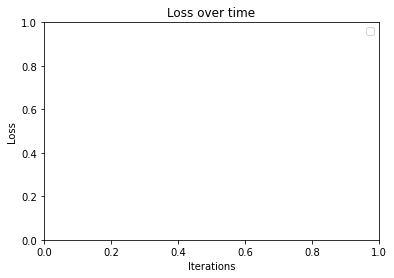

  0%|          | 0/20001 [00:00<?, ?it/s]

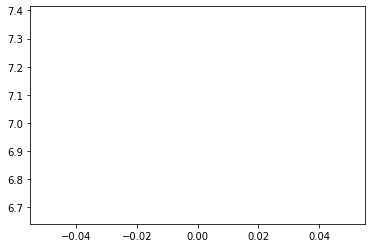

  0%|          | 100/20001 [04:32<14:42:26,  2.66s/it]

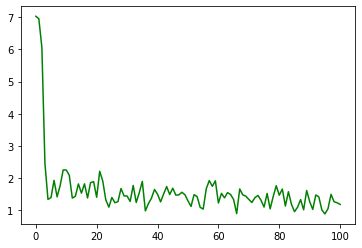

  1%|          | 154/20001 [07:00<13:28:42,  2.44s/it]

In [ ]:


##################
# Begin training!#
##################

history = []
# plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
plt.title('Loss over time')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vector_prompts, vector_responses, batch_size=batch_size)
  loss = train_step(x_batch, y_batch)

#   print("Input shape:      ", x_batch.shape, " # (batch_size, sequence_length)")
#   print("Prediction shape: ", y_batch.shape, "# (batch_size, sequence_length, vocab_size)")

  # Update the progress bar
  history.append(loss.numpy().mean())

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)
    plt.plot(range(iter + 1), history, 'g', label='Training loss')
    plt.show()

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)
# plt.plot(epochs, loss_val, 'b', label='validation loss')    plt.show()
plt.plot(range(101,num_training_iterations), history[101:num_training_iterations], 'g', label='Training loss')


In [23]:
prompts = ["hi",""]
prompts = [prompt + " startseqtok" for prompt in prompts]
print(prompts)

['hi startseqtok', ' startseqtok']


In [1]:


############## Inference ######################


# batch size None for inference, remove statefulness and allow any size input
model = build_model(vocab_size=len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=None)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

## Prediction of a chat class ###
# prompts should be a list or single string
def classify_next(prompts):

    # convert to list if needed
    prompts = [prompts] if isinstance(prompts, str) else prompts

    # up the dimension if single inference...its hacky i know...
    single_item = False
    if len(prompts) == 1:
       prompts.append("")
       single_item = True

    # add the token for starting the response sequence
    prompts = [prompt if "startseqtok" in prompt.lower() else prompt + " startseqtok" for prompt in prompts]

    # Evaluation step (generating ABC text using the learned RNN model)
    input_eval = vectorize_layer(tf.squeeze(prompts))
    pred = model(input_eval)
    pred = tf.nn.softmax(pred[:, -1, :])
    # output_labels = tf.argmax(pred, axis=1)

    # Note that this is log probs, see here https://www.tensorflow.org/api_docs/python/tf/random/categorical
    output_labels = np.array(vocab)[tf.squeeze(tf.random.categorical(pred, num_samples=1)).numpy()]

    return output_labels if not single_item else output_labels[0]


def gen_response(prompt):
  
  response = ""
  
  maxCount = 100
  count = 0
  while (count < maxCount) and ("endseqtok" not in response.lower()):
    response = response + f' {classify_next(prompt + " startseqtok " + response)}'
    count = count + 1
  
  response = response.replace("endseqtok", "")

  return response

print(gen_response("The pig did a jig."))

# def classify_label(prompts):
#     encoded_labels = classify(prompts)
#     labels = ['recycle', 'review', 'action']
#     return list(map(lambda label: labels[label], encoded_labels))

# # calculate accuracy
# pred_labels = classify(condensed_data_tensor)
# accuracy = np.sum(np.equal(
#     list(map(np.argmax, vector_target)), pred_labels))/len(condensed_data_tensor)
# print(f'Accuracy is {accuracy}')

NameError: ignored